In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Generator, Callable

# Подготовка данных

## Опреределние используемых функций

In [2]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df

def remove_outliers_with_datetime(df: pd.DataFrame, threshold_multiplier: float) -> pd.DataFrame:
    # Копируем DataFrame, чтобы сохранить оригинальные данные
    filtered_df = df.copy()
    # Список для сохранения индексов строк, которые не являются выбросами
    valid_indices = []

    # Проходим по всем столбцам, кроме последнего (DateTime)
    for column in df.columns[:-1]:
        # Вычисление среднего и стандартного отклонения
        mean = df[column].mean()
        std = df[column].std()

        # Определение границ для выбросов
        upper_threshold = mean + threshold_multiplier * std
        lower_threshold = mean - threshold_multiplier * std

        # Находим валидные строки, которые не являются выбросами
        valid_mask = (df[column] <= upper_threshold) & (df[column] >= lower_threshold)
        
        # Сохраняем индексы валидных строк для текущего столбца
        if not valid_indices:
            # Если список индексов еще пуст, инициализируем его
            valid_indices = df.index[valid_mask].tolist()
        else:
            # Объединяем индексы с уже существующими, оставляя только те, которые валидны во всех колонках
            valid_indices = [index for index in valid_indices if index in df.index[valid_mask]]

    # Отфильтровываем DataFrame, оставляя только строки с валидными индексами
    filtered_df = df.loc[valid_indices].reset_index(drop=True)

    return filtered_df


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()

def keep_columns(df: pd.DataFrame, columns_to_keep: list) -> pd.DataFrame:    
    
    # Пересечение списка существующих столбцов с запрашиваемыми для сохранения.
    columns_to_keep = [column for column in columns_to_keep if column in df.columns]

    # Сохраняем только те столбцы, которые присутствуют в columns_to_keep.
    df = df[columns_to_keep]
    return df

def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, diff1: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
  
        if (timeY - timeX > diff2) or (timeY - timeX < diff1):
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

## Загрузка файлов

In [9]:
df_Y1 = load_file('Исходные данные/Лабораторные анализы Давление насыщенных паров в продукте, зимний период.xlsx')
df_Y2 = load_file('Исходные данные/Лабораторные анализы Конец кипения легкого бензина.xlsx')
df_Y3 = load_file('Исходные данные/Лабораторные анализы Содержание олефинов в продукте.xlsx')

df_X_1all = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx'),3)
df_X_2all = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx'),3)
df_X_3all = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx'),3)

df_X1 = keep_columns(df_X_1all, ['Температура 2-ой тарелки С-1101', 'Температура ЛБ от С-1101','Температура ТБ после Е-1101', 'Расход пара на ребойлеры Е-1105','Температура сырья после Е-1103', 'Температура на выходе из H-1201', 'DateTime'])
df_X2 = keep_columns(df_X_2all, ['Давление продукта после Е-1205', 'Расход бензина на рециркуляцию от Е-1205','Давление бензина после Е-1102', 'Расход ВСГ от К-1201','Температура на входе в R-1201', 'Температура ВСГ на выходе из К-1201', 'Давление сырья перед Е-1101', 'Давление продукта на выходе с установки', 'Расход ЛБ на орошение С-1101', 'Температура окружающей среды', 'Температура ЛБ от С-1101', 'Температура ЛБ после АВО А-1101', 'Расход ЛБ от С-1101', 'Температура 9-ой тарелки С-1101', 'DateTime'])
df_X3 = keep_columns(df_X_3all, ['4FIC1003_PIDA_PV/Var/MV/Расход водорода на смешение перед Е-1101/', '4TI2092_DACA_PV/Var/MV/Температура питания С-1202/', '4FIC1012_PIDA_PV/Var/MV/Расход ЛБ на орошение С-1101/','4FIC1015_PIDA_SP/Var/MV/Расход ЛБ от С-1101/', '4FI3401_DACA_PV/Var/MV/Расход бензина ККР на установку/', '4PI2058_DACA_PV/Var/MV/Давление продукта после Е-1205/', '4TI2081_DACA_PV/Var/MV/Температура куба С-1202/', '4LIC2001_PIDA_PV/Var/MV/Уровень в емкости V-1201/', '4TI1047_DACA_PV/Var/MV/Температура куба С-1101/', '4TIC2085_PIDA_PV/Var/MV/Температура после А-1202/', 'DateTime'])



In [10]:
df_Y1

,"Давление насыщенных паров, зимний период, кПа",DateTime
0,49.8,2022-01-01 11:21:00
1,52.3,2022-01-02 10:50:00
2,50.7,2022-01-03 10:24:48
3,52.6,2022-01-04 11:12:49
4,54.7,2022-01-05 10:23:28
...,...,...
291,59.3,2023-12-05 11:30:47
292,57.4,2023-12-07 10:21:11
307,56.9,2024-01-30 11:27:17
308,60.7,2024-02-01 11:17:48


In [11]:
df_X1

,Температура 2-ой тарелки С-1101,Температура ЛБ от С-1101,Температура ТБ после Е-1101,Расход пара на ребойлеры Е-1105,Температура сырья после Е-1103,Температура на выходе из H-1201,DateTime
0,61.33,95.72,100.65,100.84,161.23,303.00,2022-01-08 17:35:00
1,61.41,95.60,101.93,99.71,161.06,300.81,2022-01-08 19:00:00
2,61.00,95.39,101.09,99.42,161.20,300.84,2022-01-08 20:25:00
3,61.49,95.28,100.72,99.36,161.17,300.82,2022-01-08 21:50:00
4,61.29,95.19,100.96,100.72,161.10,300.12,2022-01-08 23:15:00
...,...,...,...,...,...,...,...
11565,63.25,92.58,100.05,102.00,163.06,282.93,2024-02-06 20:00:00
11566,62.44,92.09,99.65,102.08,162.93,282.67,2024-02-06 21:00:00
11567,62.06,91.96,99.38,102.00,162.85,282.38,2024-02-06 22:00:00
11568,61.94,92.24,98.94,102.59,162.89,281.91,2024-02-06 23:00:00


В загруженных файлах заменены пропуски, которые в таблице обозначены "-" на NaN значения, эти строки отброшены.

## Анализ данных

In [12]:
pd.set_option('display.max_columns', None)
min_var = 0.01

In [13]:
def dataframe_info(df):
    df = df.drop(columns=['DateTime'])
    variance = df.var()
    std = df.std()
    means = df.mean()
    medians = df.median()
    mins = df.min()
    maxes = df.max()
    df_info = pd.DataFrame([variance, std, means, medians, mins, maxes], index=['variance', 'standart deviation', 'mean', 'median', 'min', 'max'])
    return df_info

def drop_low_variance(df, df_info, min_var):
    df2 = df[df.columns[:-1]].T
    m1 = df_info.loc['variance'] < min_var
    drop_cols =  df2.loc[m1].T.columns
    df.drop(columns=list(drop_cols), inplace=True)

Простоим таблицу основных статистических величин для каждой переменной в каждом датасете, отбросим те величины, дисперсия которых меньше чем min_var, постоим графики плотности распределения каждой из сотавшихся величин

## X1

In [14]:
df_info_X1 = dataframe_info(df_X1)
df_info_X1

,Температура 2-ой тарелки С-1101,Температура ЛБ от С-1101,Температура ТБ после Е-1101,Расход пара на ребойлеры Е-1105,Температура сырья после Е-1103,Температура на выходе из H-1201
variance,35.712413,4.744477,12.155287,165.493058,20.245715,102.517561
standart deviation,5.975986,2.178182,3.486443,12.864411,4.499524,10.125096
mean,65.456670,94.739262,104.729403,101.869348,161.010933,301.830243
median,65.430000,94.975000,104.960000,105.370000,161.040000,301.130000
min,51.000000,80.540000,92.470000,31.000000,130.340000,273.150000
max,83.590000,101.290000,115.180000,130.760000,173.420000,328.970000


In [15]:
drop_low_variance(df_X1, df_info_X1, min_var)

C:\Users\PC\AppData\Local\Temp\ipykernel_17288\4217600152.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=list(drop_cols), inplace=True)


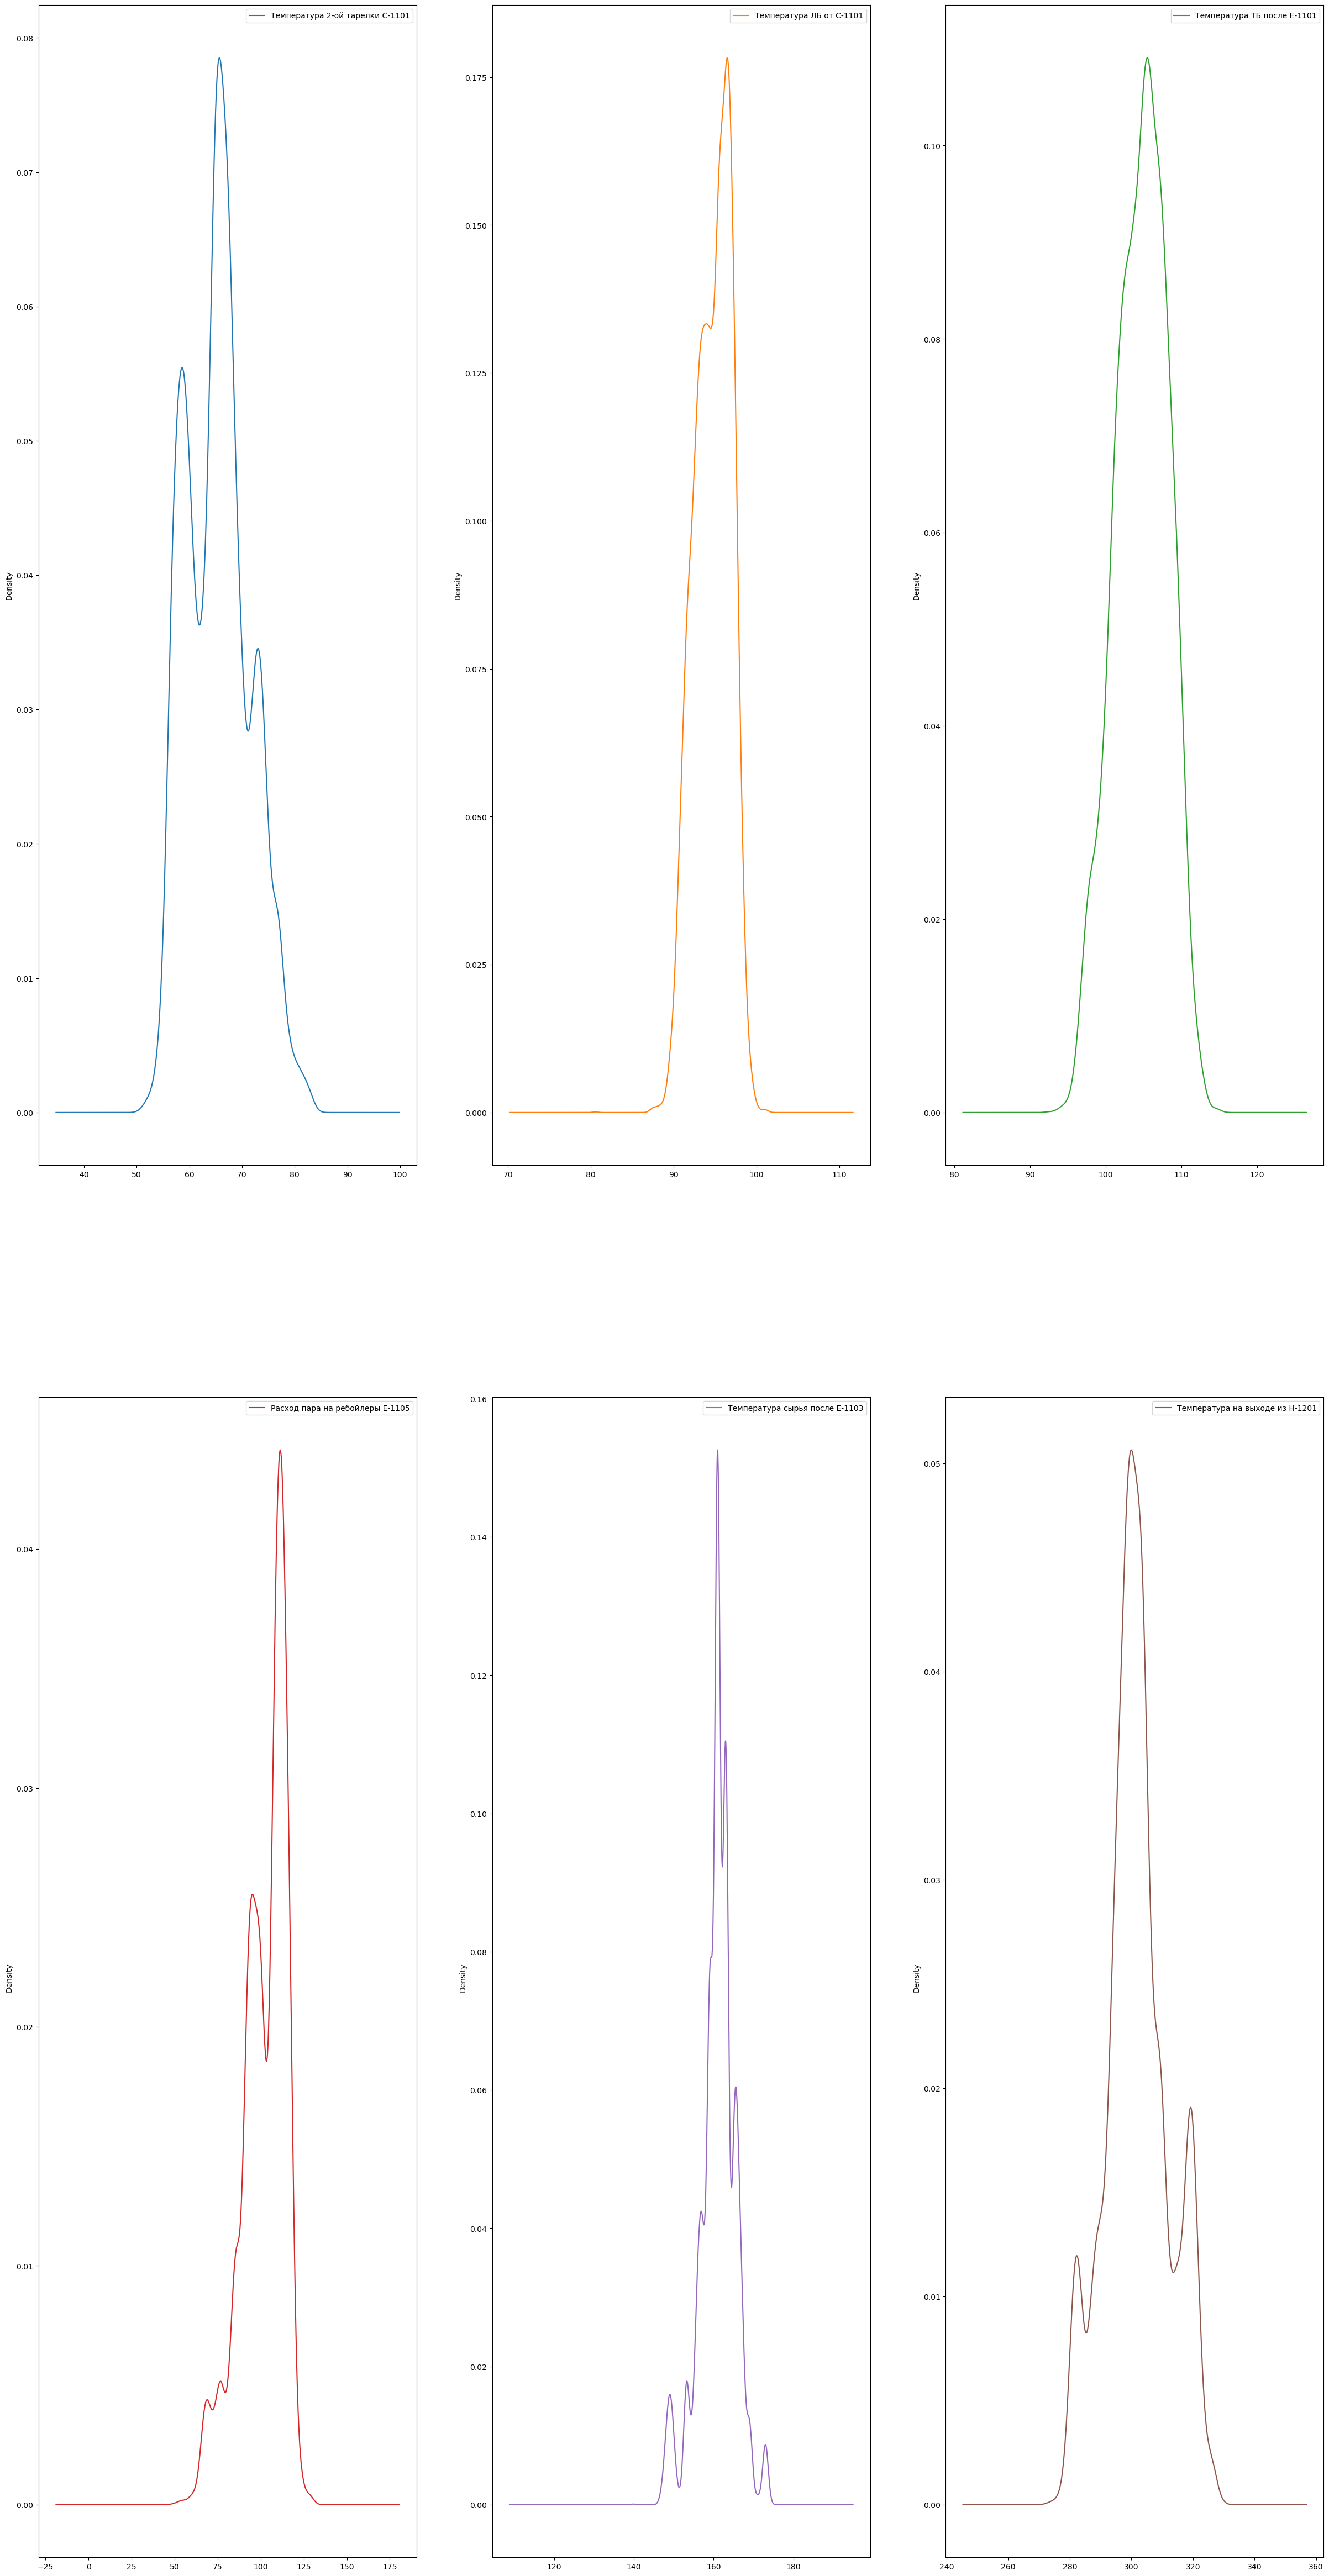

In [16]:
df_X1[df_X1.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X2

In [17]:
df_info_X2 = dataframe_info(df_X2)
df_info_X2

,Давление продукта после Е-1205,Расход бензина на рециркуляцию от Е-1205,Давление бензина после Е-1102,Расход ВСГ от К-1201,Температура на входе в R-1201,Температура ВСГ на выходе из К-1201,Давление сырья перед Е-1101,Давление продукта на выходе с установки,Расход ЛБ на орошение С-1101,Температура окружающей среды,Температура ЛБ от С-1101,Температура ЛБ после АВО А-1101,Расход ЛБ от С-1101,Температура 9-ой тарелки С-1101
variance,1.620335,30.966677,0.022131,3.478242e+06,43.544363,10.242524,0.011504,0.015130,185.715475,77.511794,4.845316,127.768110,67.576367,8.171275
standart deviation,1.272924,5.564771,0.148764,1.865004e+03,6.598815,3.200394,0.107257,0.123004,13.627746,8.804078,2.201208,11.303456,8.220485,2.858544
mean,3.083454,2.614966,27.618275,5.173095e+04,244.735577,49.852950,29.057929,0.313384,104.323856,15.262496,94.726342,38.272110,73.336890,114.848407
median,3.860000,0.000000,27.620000,5.148313e+04,244.520000,49.600000,29.070000,0.300000,104.030000,15.150000,94.930000,35.070000,74.160000,114.790000
min,0.520000,0.000000,24.870000,4.737671e+04,221.230000,39.850000,26.100000,0.050000,64.190000,-5.560000,80.540000,15.550000,44.310000,99.540000
max,4.540000,28.840000,28.080000,6.689415e+04,263.210000,59.660000,29.250000,0.930000,149.120000,37.570000,101.290000,56.520000,98.910000,127.090000


In [18]:
drop_low_variance(df_X2, df_info_X2, min_var)

C:\Users\PC\AppData\Local\Temp\ipykernel_17288\4217600152.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=list(drop_cols), inplace=True)


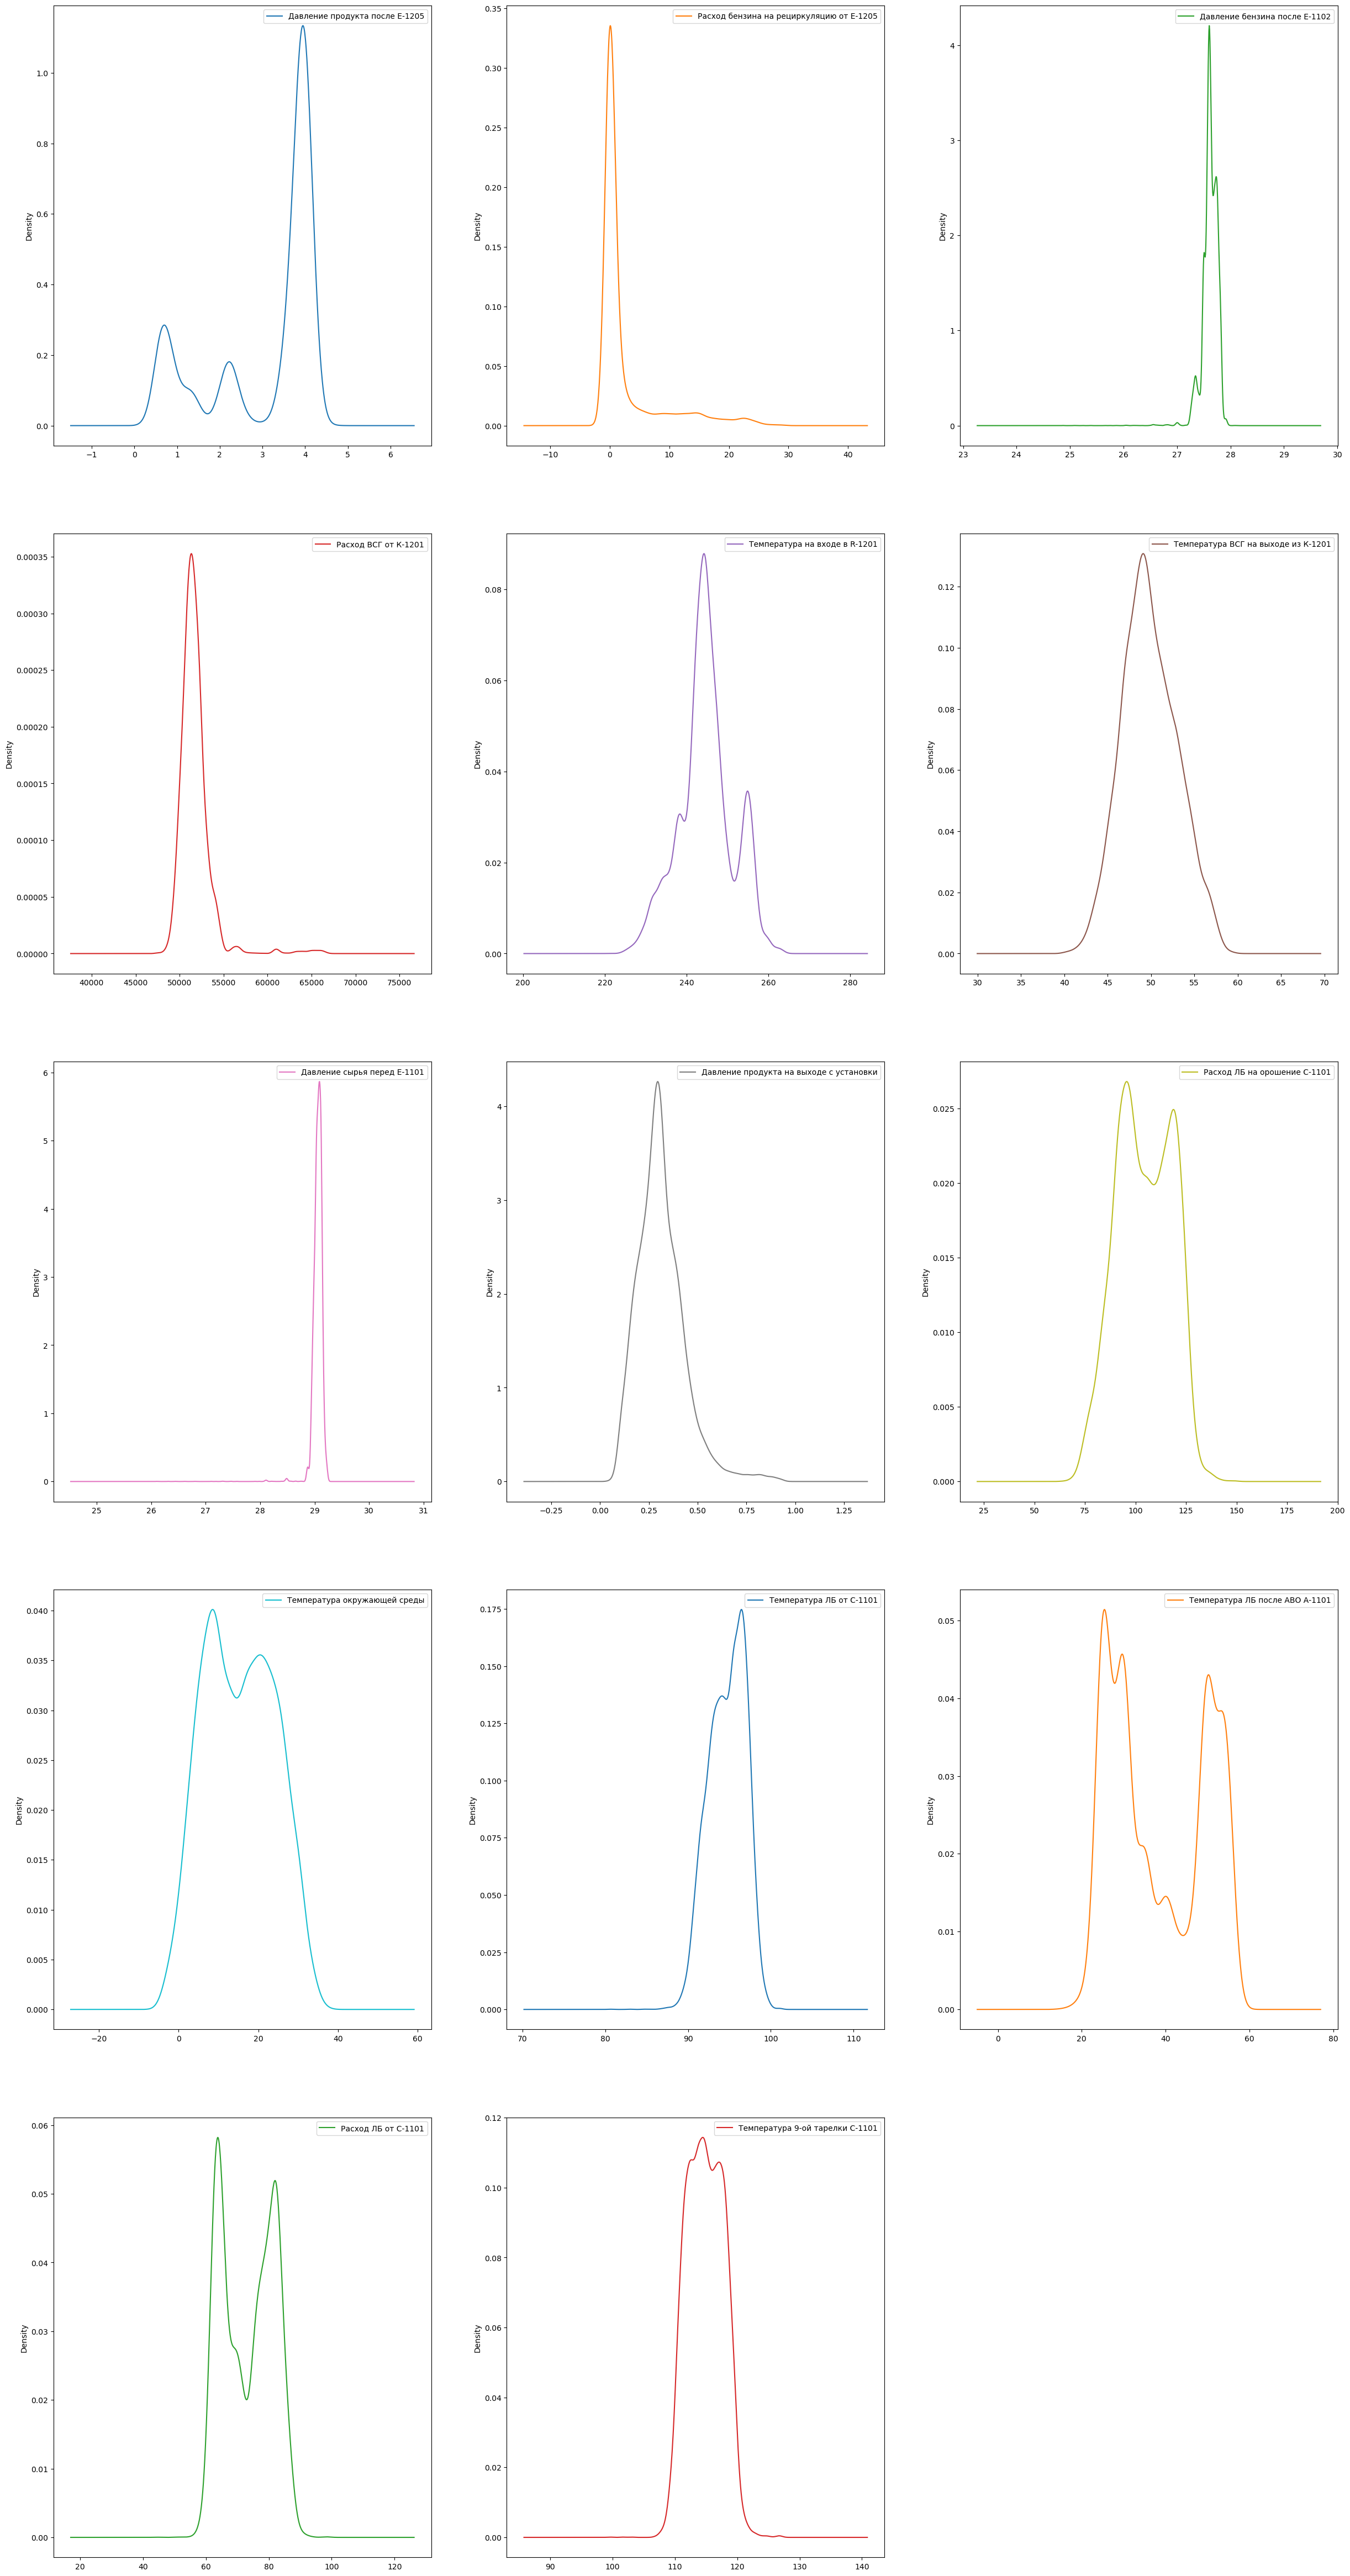

In [19]:
df_X2[df_X2.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X3

In [20]:
df_info_X3 = dataframe_info(df_X3)
df_info_X3

,4FIC1003_PIDA_PV/Var/MV/Расход водорода на смешение перед Е-1101/,4TI2092_DACA_PV/Var/MV/Температура питания С-1202/,4FIC1012_PIDA_PV/Var/MV/Расход ЛБ на орошение С-1101/,4FIC1015_PIDA_SP/Var/MV/Расход ЛБ от С-1101/,4FI3401_DACA_PV/Var/MV/Расход бензина ККР на установку/,4PI2058_DACA_PV/Var/MV/Давление продукта после Е-1205/,4TI2081_DACA_PV/Var/MV/Температура куба С-1202/,4LIC2001_PIDA_PV/Var/MV/Уровень в емкости V-1201/,4TI1047_DACA_PV/Var/MV/Температура куба С-1101/,4TIC2085_PIDA_PV/Var/MV/Температура после А-1202/
variance,22640.815733,7.325468,182.529372,67.562381,168.905469,1.643317,1.701761,1.059088,1.410046,123.958455
standart deviation,150.468654,2.706560,13.510343,8.219634,12.996364,1.281919,1.304516,1.029120,1.187454,11.133663
mean,827.161011,156.910990,104.351581,73.548913,102.170861,3.069123,185.050598,59.089149,185.379799,33.472579
median,859.880000,156.130000,104.070000,75.000000,105.940000,3.860000,185.140000,59.950000,185.450000,29.765000
min,230.770000,91.930000,66.930000,52.190000,31.360000,0.520000,173.070000,54.490000,174.610000,6.260000
max,1124.950000,162.880000,149.120000,98.910000,136.320000,4.540000,188.520000,61.420000,189.430000,59.100000


In [21]:
drop_low_variance(df_X3, df_info_X3, min_var)

C:\Users\PC\AppData\Local\Temp\ipykernel_17288\4217600152.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=list(drop_cols), inplace=True)


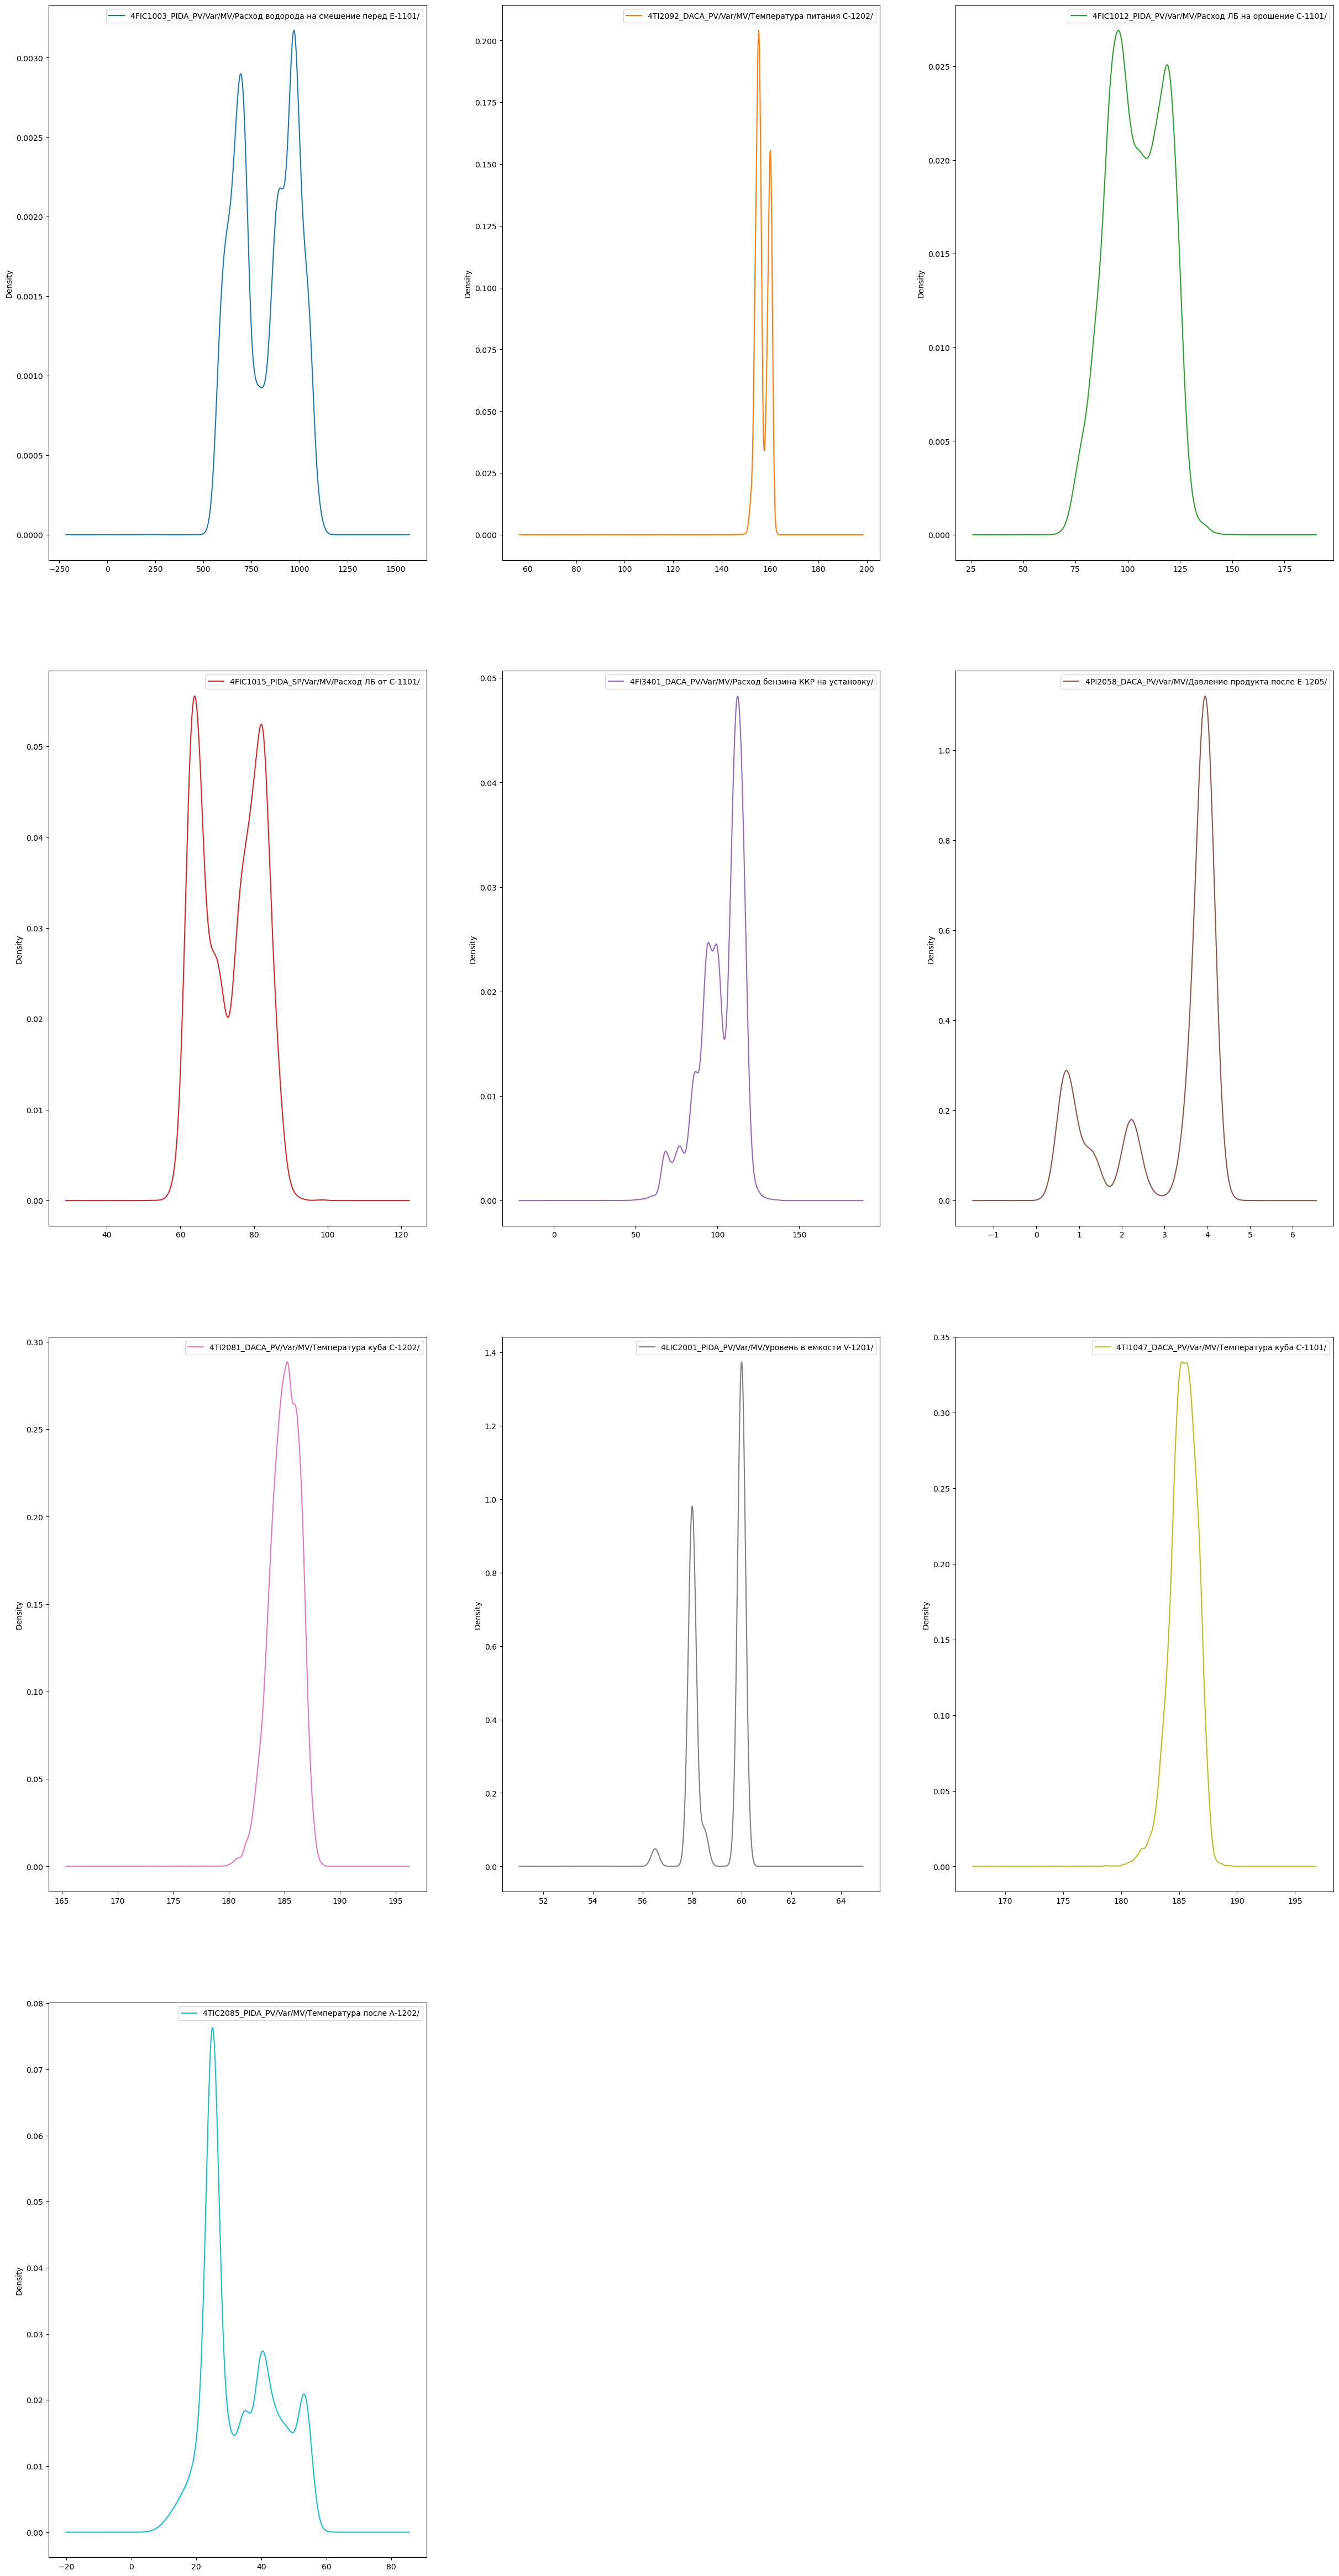

In [22]:
df_X3[df_X3.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

Посмотрим, какая регулярность измерений процессорных данных. Для этого построим гистограмму распределения временного промежутка (в минутах) между двумя соседними измерениями.
Лабораторные анализы проиводились крайне нерегулярно, для них такая диаграмма не имеет смысла.

Counter({Timedelta('0 days 01:27:55'): 5437, Timedelta('0 days 01:29:20'): 1914, Timedelta('0 days 01:25:00'): 1735, Timedelta('0 days 01:27:50'): 1471, Timedelta('0 days 01:00:00'): 880, Timedelta('0 days 02:55:50'): 18, Timedelta('0 days 02:55:40'): 8, Timedelta('0 days 04:23:45'): 8, Timedelta('0 days 05:51:40'): 7, Timedelta('0 days 07:19:35'): 6, Timedelta('0 days 04:28:00'): 6, Timedelta('0 days 02:50:00'): 5, Timedelta('0 days 00:11:15'): 4, Timedelta('0 days 05:51:20'): 4, Timedelta('0 days 04:15:00'): 3, Timedelta('0 days 04:23:30'): 3, Timedelta('0 days 08:56:00'): 3, Timedelta('0 days 05:57:20'): 3, Timedelta('0 days 09:55:00'): 2, Timedelta('0 days 07:05:00'): 2, Timedelta('0 days 22:40:00'): 2, Timedelta('0 days 02:27:50'): 2, Timedelta('0 days 07:26:40'): 2, Timedelta('0 days 02:58:40'): 2, Timedelta('0 days 00:27:55'): 2, Timedelta('0 days 01:11:15'): 2, Timedelta('0 days 08:47:30'): 2, Timedelta('0 days 11:20:00'): 1, Timedelta('0 days 00:45:00'): 1, Timedelta('3 days 2

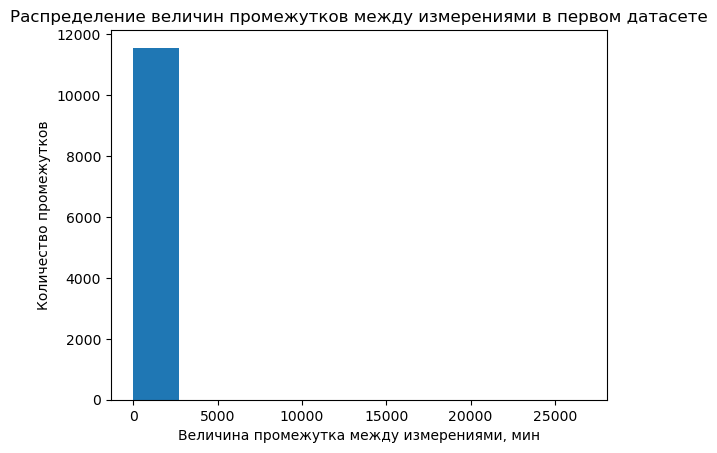

In [23]:
plot_timedelta_distr(df_X1, "Распределение величин промежутков между измерениями в первом датасете")

Как мы видим, даже процессорные измерения были не полностью регулярные, что может сказаться на количестве процессорных значений, соответствующих одному лабораторному анализу

Пройдёмся по нашим процессорным данным и поставим в соответствие лабораторным измерениям те процессорные данные, которые были получены не дальше чем diff времени до лабораторного анализа или diff2 времени после лабораторного анализа

In [24]:
diff1 = pd.to_timedelta('2h')
diff2 = pd.to_timedelta('4h')

Количество точек 134 

Распределение количества примеров 
 Counter({1: 57, 2: 50, 0: 27}) 



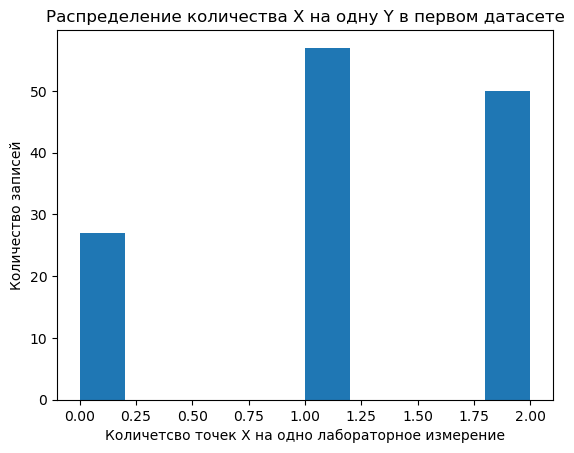

In [25]:
plot_num_distr(construct_XY(df_X1, df_Y1, diff1, diff2), "Распределение количества X на одну Y в первом датасете")

Количество точек 110 

Распределение количества примеров 
 Counter({1: 66, 2: 39, 0: 5}) 



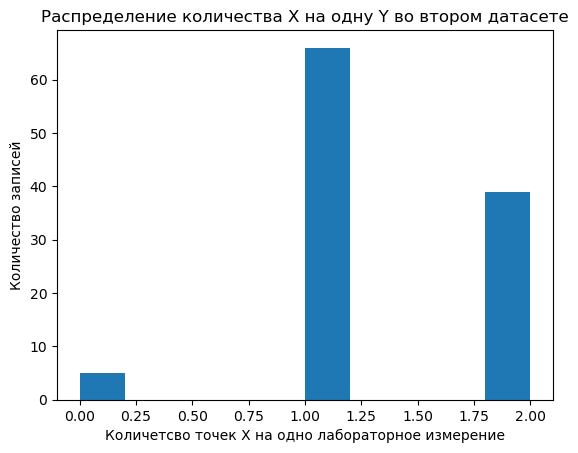

In [26]:
plot_num_distr(construct_XY(df_X2, df_Y2, diff1, diff2), "Распределение количества X на одну Y во втором датасете")

Количество точек 226 

Распределение количества примеров 
 Counter({1: 125, 2: 83, 0: 18}) 



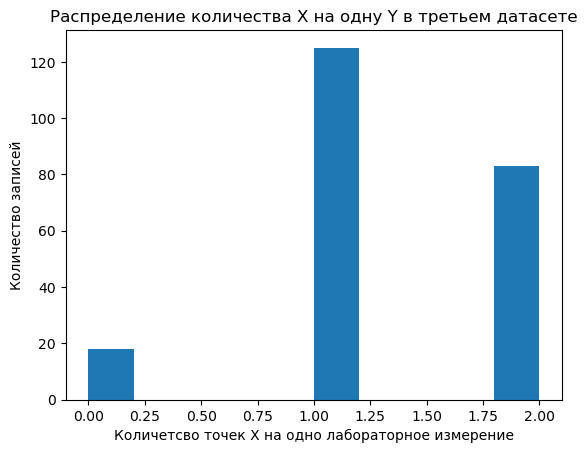

In [27]:
plot_num_distr(construct_XY(df_X3, df_Y3, diff1, diff2), "Распределение количества X на одну Y в третьем датасете")

Как мы видим, при данных временных рамках одному лабораторному анализу может соответствовать от нуля до пяти процессорных данных. Чтобы иметь возможность адекватно обрабатывать данные, необходимо отбросить точки без процессорных данных и свести процессорные данные к единому формату. 
Подобная обработка процессорных данных может быть проделана, используя среднее или экпоенециальное среднее

## Формирование тестовой и обучающей выборки

## Описание функций

Функция формирования тестовой и обучающей выборки в numpy массивов, значения Х в каждой точке агрегируются в вектор. На вход подаётся свежий экземпляр генератора точек X и Y и функция агрегирования

In [28]:
def form_datasets(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    return all_X, all_Y_with_timestamps

def form_datasets_cat(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []
    all_X_season = []  # Создаем список для сезонного столбца

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)
            # Добавляем значение в список сезонного столбца
            all_X_season.append(1 if 4 <= timestamp.month <= 9 else 0)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)
    all_X_season = np.array(all_X_season, dtype=np.float64).reshape(-1, 1)  # Преобразуем список в массив NumPy

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    # Добавляем сезонный столбец к all_X
    all_X = np.hstack((all_X, all_X_season))

    return all_X, all_Y_with_timestamps

Функция агрегирования, обобщающая использование арифметического среднего, последнего значения и взвешенного экпоненциального среднего

In [29]:
def exp_average(arr: np.ndarray, alpha=0) -> np.ndarray:
    """Функция взвешенного среднего для агрегирования значений X. При alpha = 0 результат - арифметическое среднее, 
    при alpha = 1 результат - последнее значение, при alpha = (0, 1) результат - экспоненциальное взвешенное среднее"""

    arr = arr[::-1]
    out_arr = np.zeros(arr.shape[1])
    coeff_sum = 0
    for pow, row in enumerate(arr):
        coeff = (1-alpha)**pow
        out_arr = out_arr + row*coeff
        coeff_sum += coeff
    
    out_arr = out_arr/coeff_sum
    return out_arr

Сохранение данных в .npz архив

In [30]:
def save_datasets(gen1, gen2_cat, gen3_cat, df_X1,df_X2,df_X3,func, func_name) -> None:
    """Генерирует и сохраняет датасеты с определённой функцией агрегирования func в .npz архив под именем Data_func_name.npz"""
    column_names_1 = df_X1.columns[:-1].tolist()
    column_names_2_cat = df_X2.columns[:-1].tolist()
    column_names_2_cat += ['Время года(1 - лето,0 - зима)']
    column_names_3_cat = df_X3.columns[:-1].tolist()
    column_names_3_cat += ['Время года(1 - лето,0 - зима)']
    all_X_1, all_Y_1 = form_datasets(gen1, func)
    all_X_2, all_Y_2 = form_datasets_cat(gen2_cat,func)
    all_X_3, all_Y_3 = form_datasets_cat(gen3_cat,func)
    
    np.savez_compressed(
        "Data_" + func_name +".npz", 
        all_X_1 = all_X_1, all_Y_1=all_Y_1, 
        all_X_2 = all_X_2, all_Y_2 = all_Y_2,
        all_X_3 = all_X_3, all_Y_3 = all_Y_3,
        column_names_1 = column_names_1, column_names_2_cat = column_names_2_cat, column_names_3_cat = column_names_3_cat,
    )                 

## Сохранение размеченных данных

Сохраним архивы с 3 вариантами агрегирования (арифметическое среднее, последнее измерение, взвешенное экспоненциальное среднее. 

В каждом архиве находятся по 4 массива для 3 виртуальных анализаторов. Номер ВА - последняя цифра в названии массива (1 - Давление насыщенных паров в продукте, зимний период, 2 - Конец кипения легкого бензина, 3 - Содержание олефинов в продукте). 

Каждый массив построен по следующему принципу Y[N], X[N, C], где N - номер точки, C - номер процессорного значения.

In [31]:
save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    df_X1,
    df_X2,
    df_X3,
    lambda x: exp_average(x, alpha=0),
    "Average_ilya"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    df_X1,
    df_X2,
    df_X3,
    lambda x: exp_average(x, alpha=1),
    "First_ilya"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    df_X1,
    df_X2,
    df_X3,
    lambda x: exp_average(x, alpha=0.5),
    "Exponential_Average_ilya"
)

In [32]:
df_X1.to_csv('raw_X1.csv')
df_X2.to_csv('raw_X2.csv')
df_X3.to_csv('raw_X3.csv')

df_Y1.to_csv('raw_Y1.csv')
df_Y2.to_csv('raw_Y2.csv')
df_Y3.to_csv('raw_Y3.csv')